# Automated-Wafer-Defect-Detection-and-Pattern-Recognition-Using-Deep-Learning

datasets: https://www.kaggle.com/datasets/qingyi/wm811k-wafer-map

Reference paper:
Wu, Ming-Ju, Jyh-Shing R. Jang, and Jui-Long Chen. “Wafer Map Failure Pattern Recognition and Similarity Ranking for Large-Scale Data Sets.” IEEE Transactions on Semiconductor Manufacturing 28, no. 1 (February 2015): 1–12.

In [1]:
# Load package
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
plt.style.use('seaborn')
sns.set(font_scale=2) 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from PIL import Image

/var/folders/ww/2phdrqvx0k7b9qmqm0v7m2s40000gn/T/ipykernel_93526/1745665795.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Data Cleaning and EDA

In [2]:
# Data
df_original = pd.read_pickle("../datasets/LSWMD.pkl")
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [3]:
df_original.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [4]:
# Assuming df is your DataFrame
df = df_original.sample(frac=0.1, random_state=42)


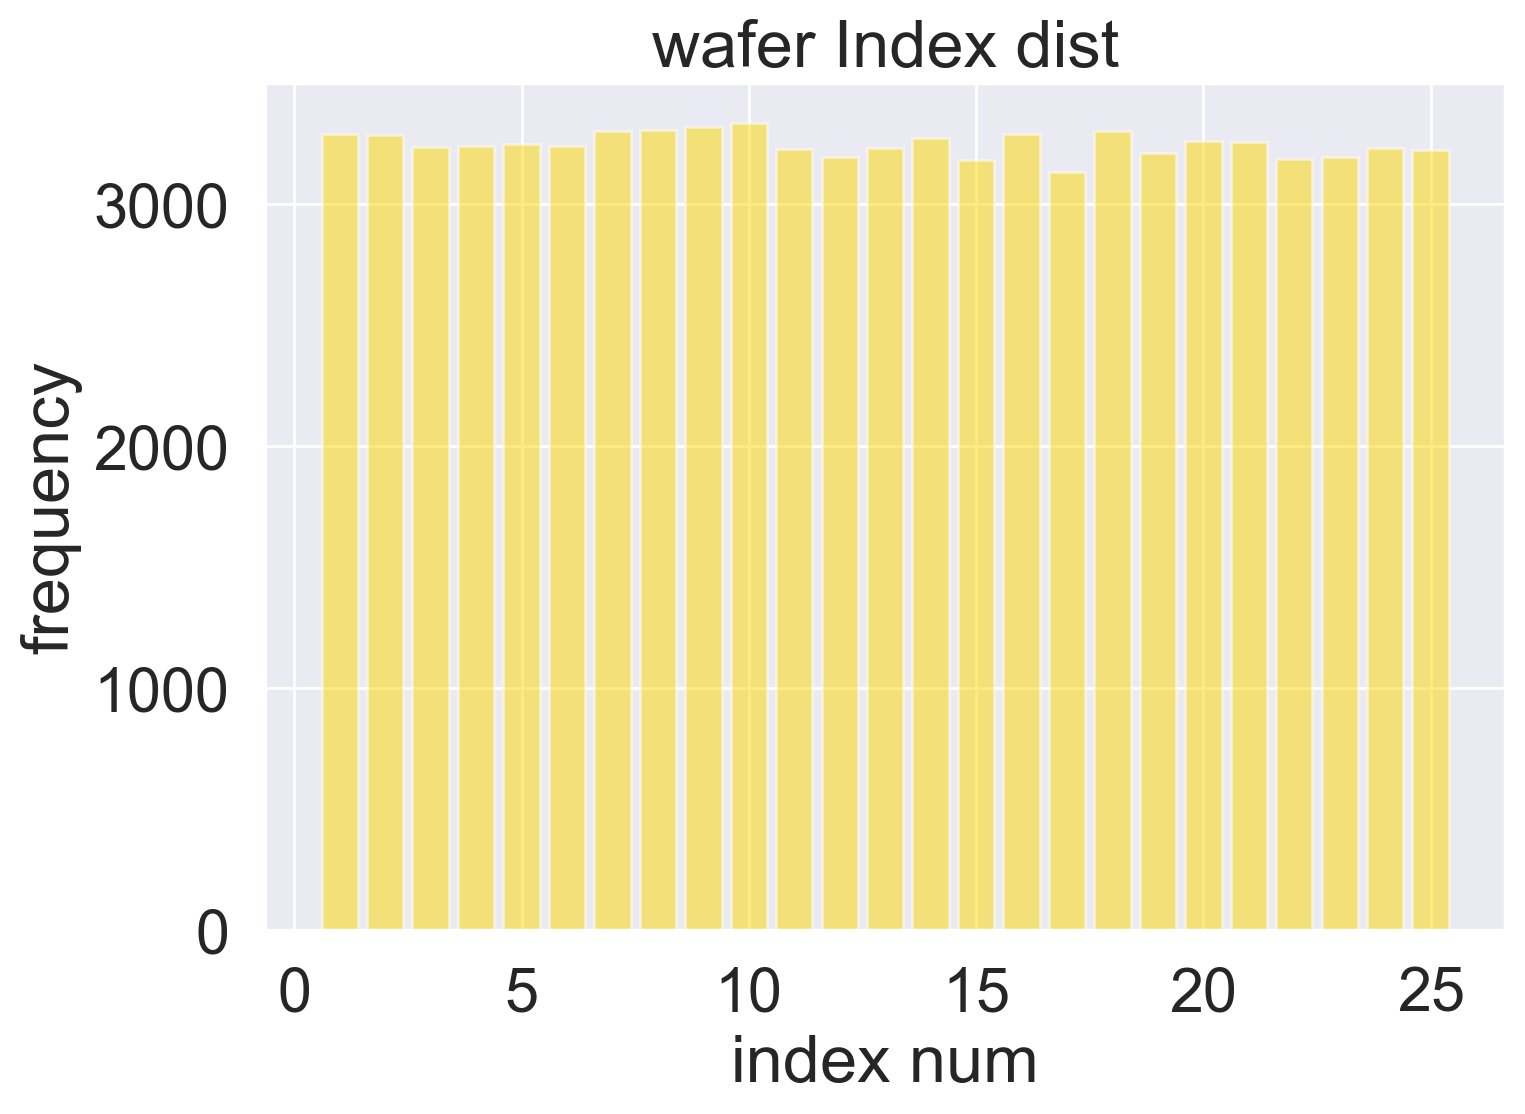

In [5]:
# 1. The distribution of lot_idx and num_wafer
lot_index = np.unique(df.waferIndex, return_counts=True)
plt.bar(lot_index[0], lot_index[1], color='gold', align='center', alpha=0.5)
plt.title("wafer Index dist")
plt.xlabel("index num")
plt.ylabel("frequency")
# plt.ylim(30000, 34000)
plt.show()

In [6]:
# Drop column
df = df.drop(['waferIndex'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81146 entries, 552336 to 147401
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   waferMap        81146 non-null  object 
 1   dieSize         81146 non-null  float64
 2   lotName         81146 non-null  object 
 3   trianTestLabel  81146 non-null  object 
 4   failureType     81146 non-null  object 
dtypes: float64(1), object(4)
memory usage: 3.7+ MB


In [7]:
# 2. Add wafermapDim column because waferMap dim is different each other.
def find_dim(x):
    dim0 = np.size(x, axis=0)
    dim1 = np.size(x, axis=1)
    return dim0, dim1
df['waferMapDim']= df['waferMap'].apply(lambda x: find_dim(x))
df.head(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
552336,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot34696,[],[],"(32, 29)"
24803,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",776.0,lot2724,[],[],"(30, 34)"
426607,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6052.0,lot25655,[],[],"(86, 89)"
722885,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1,...",518.0,lot43945,[[Test]],[[none]],"(25, 26)"
192536,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6328.0,lot12178,[],[],"(89, 90)"


In [8]:
# 3. To check failureType distribution and encoding label
df['failureNum'] = df['failureType']
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
df = df.replace({'failureNum':mapping_type})

In [9]:
# df_withlabel : labeled wafer
# df_withpattern : labeled & patterned wafer 
# df_nonpatter : labeled but non-patterned wafer
df_withlabel = df[(df['failureType']!=0)]
df_withlabel =df_withlabel.reset_index() #labeled index.
df_withpattern = df_withlabel[(df_withlabel['failureType'] != 'none')]
df_withpattern = df_withpattern.reset_index() #patterned index.
df_nonpattern = df_withlabel[(df_withlabel['failureType'] == 'none')] #nonpatterned index
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(17383, 2624, 14759)

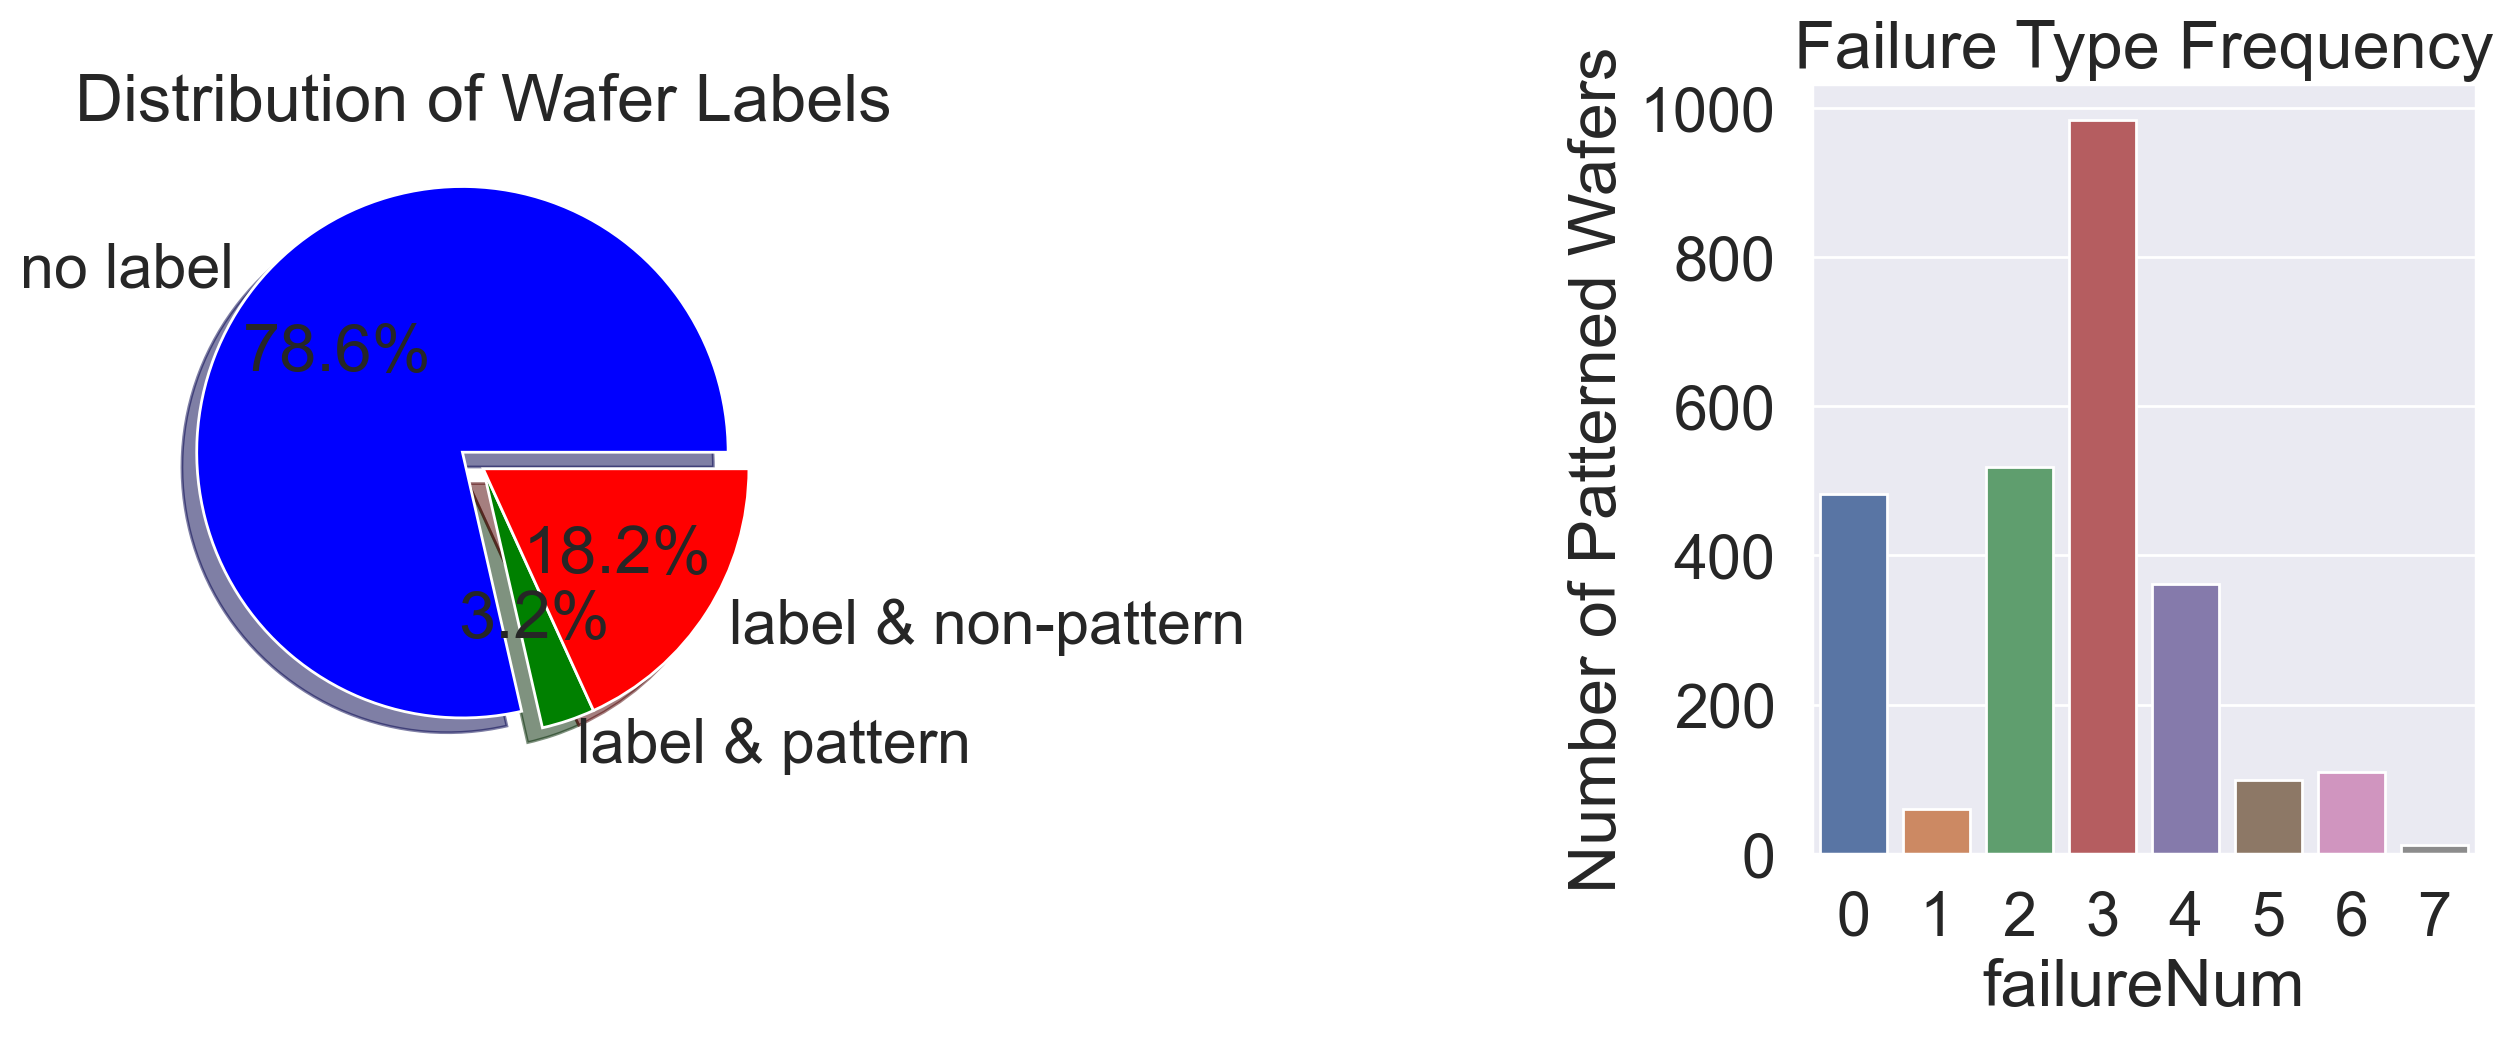

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
colors = ['blue', 'green', 'red']
num_wafers = [len(df['waferMap']) - df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]
labels = ['no label', 'label & pattern', 'label & non-pattern']

# Pie chart
ax[0].pie(num_wafers, explode=(0.1, 0, 0), labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
ax[0].set_title('Distribution of Wafer Labels')

# Count plot
sns.countplot(x='failureNum', data=df_withpattern, ax=ax[1])
ax[1].set_title("Failure Type Frequency")
ax[1].set_ylabel("Number of Patterned Wafers")

plt.subplots_adjust(wspace=1.5)
plt.show()


In [11]:
# Display value counts with a more descriptive title
value_counts = df_withlabel['waferMapDim'].value_counts()
print("Counts of Each Wafer Map Dimension:")
print(value_counts)


Counts of Each Wafer Map Dimension:
waferMapDim
(25, 27)    1808
(26, 26)    1405
(30, 34)    1299
(29, 26)    1203
(27, 25)    1066
            ... 
(54, 42)       1
(28, 28)       1
(34, 35)       1
(41, 56)       1
(39, 45)       1
Name: count, Length: 218, dtype: int64


### Choose a subset of data
We choose the data with labels among two most popular group dim (25,27) & (26,26)

The `subwafer` function processes wafer map data from a DataFrame and prepares it for model training or analysis. It extracts and reshapes data based on specified wafer map dimensions and converts it into PyTorch tensors.

### Objectives:
- Extract wafer map data with specific dimensions from the DataFrame.
- Convert the wafer map data to PyTorch tensors.
- Prepare the data and labels for further analysis or model training.

### Inputs:
- **`sw`** (Tensor): A tensor with initial wafer map data, shaped as `(1, Dim0, Dim1)`.
- **`label`** (List): A list to be populated with failure types corresponding to each wafer map.

### Process:
1. **Extract Dimensions:** Determine the dimensions (`Dim0` and `Dim1`) of the wafer map from the `sw` tensor.
2. **Filter DataFrame:** Filter `df_withlabel` to select rows where `waferMapDim` matches the extracted dimensions.
3. **Convert to Tensor:** Convert the initial `sw` tensor to a PyTorch tensor with the data type `float32`.
4. **Iterate and Append:** For each row in the filtered DataFrame:
   - Reshape the wafer map data.
   - Convert the reshaped data to a PyTorch tensor.
   - Append the tensor to the `sw` tensor.
   - Append the corresponding failure type to the `label` list.
5. **Prepare Output:** 
   - Slice off the initial dummy entry in `sw`.
   - Reshape the `label` list into a NumPy array.
   - Return the processed tensor and label array.

### Outputs:
- **`x`** (Tensor): The tensor containing the processed wafer map data.
- **`y`** (Array): The NumPy array containing the corresponding failure types.

In [12]:
import torch
import numpy as np

def subwafer(sw, label):
    Dim0 = np.size(sw, axis=1)
    Dim1 = np.size(sw, axis=2)
    sub_df = df_withlabel.loc[df_withlabel['waferMapDim'] == (Dim0, Dim1)]
    sub_wafer = sub_df['waferMap'].values
    # Ensure sw is a tensor
    sw = torch.tensor(sw, dtype=torch.float32)  # Adjust dtype as needed
    for i in range(len(sub_df)):
        waferMap = torch.from_numpy(sub_df.iloc[i,:]['waferMap'].reshape(1, Dim0, Dim1))
        # Append to sw tensor
        sw = torch.cat([sw, waferMap])
        label.append(sub_df.iloc[i,:]['failureType'][0][0])
    x = sw[1:]
    y = np.array(label).reshape((-1,1))
    return x, y

# Create example tensors
sw0 = torch.ones((1, 25, 27))
sw1 = torch.ones((1, 26, 26))
label0 = list()
label1 = list()
x0, y0 = subwafer(sw0, label0)
x1, y1 = subwafer(sw1, label1)
print(x0.shape, x1.shape)


/var/folders/ww/2phdrqvx0k7b9qmqm0v7m2s40000gn/T/ipykernel_93526/1487647533.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sw = torch.tensor(sw, dtype=torch.float32)  # Adjust dtype as needed


torch.Size([1808, 25, 27]) torch.Size([1405, 26, 26])


### One-Hot encoding for image

 RGB Space for One-Hot Encoding

Convert wafer maps into RGB space with one-hot encoding to represent different categories:

- **0: Non-wafer** -> Red channel (R)
- **1: Normal die** -> Green channel (G)
- **2: Defect die** -> Blue channel (B)

### Function: `rgb_sw`

**Purpose:** Transform wafer map data into RGB format.

**Inputs:**
- **`x`**: 3D array or tensor of wafer maps (shape: `(num_samples, Dim0, Dim1)`).

**Output:**
- **`new_x`**: 4D array with RGB-encoded wafer maps (shape: `(num_samples, Dim0, Dim1, 3)`).


In [13]:
# Add RGB space for one-hot encoding
# 0: non wafer -> R, 1: normal die -> G, 2: defect die -> B

def rgb_sw(x):
    Dim0 = np.size(x, axis=1)
    Dim1 = np.size(x, axis=2)
    new_x = np.zeros((len(x), Dim0, Dim1, 3))
    x = torch.unsqueeze(x,-1)
    x = x.to(torch.device('cpu'))
    x = x.numpy()
    for w in range(len(x)): 
        for i in range(Dim0):
            for j in range(Dim1):
                new_x[w, i, j, int(x[w, i, j])] = 1
    return new_x

rgb_x0 = rgb_sw(x0)
rgb_x1 = rgb_sw(x1)

/var/folders/ww/2phdrqvx0k7b9qmqm0v7m2s40000gn/T/ipykernel_93526/3242365624.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_x[w, i, j, int(x[w, i, j])] = 1


### Reshape data

In [14]:
import torch
import numpy as np
from PIL import Image

def resize(x, device='cpu'):
    """
    Resize wafer map data to 56x56 pixels and convert to RGB format.

    Parameters:
    - x (np.array): 4D array of wafer maps in RGB format (shape: (num_samples, Dim0, Dim1, 3)).
    - device (str): Device to use ('cpu' or 'cuda').

    Returns:
    - x (torch.Tensor): Resized 4D tensor of wafer maps (shape: (num_samples, 56, 56, 3)).
    """
    # Initialize tensor for resized wafer maps
    rwm = torch.ones((1, 56, 56, 3), device=device)
    
    for i in range(len(x)):
        # Resize each wafer map
        a = Image.fromarray(x[i].astype('uint8')).resize((56, 56))
        a = np.array(a).reshape((1, 56, 56, 3))
        a = torch.from_numpy(a).to(device)
        
        # Append resized wafer map to tensor
        rwm = torch.cat([rwm, a])

    # Return resized wafer maps, excluding the initial dummy tensor
    return rwm[1:]

# Determine device (CPU or GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Resize wafer maps
resized_x0 = resize(rgb_x0, device=device)
resized_x1 = resize(rgb_x1, device=device)

print(resized_x0.shape, resized_x1.shape)


torch.Size([1808, 56, 56, 3]) torch.Size([1405, 56, 56, 3])


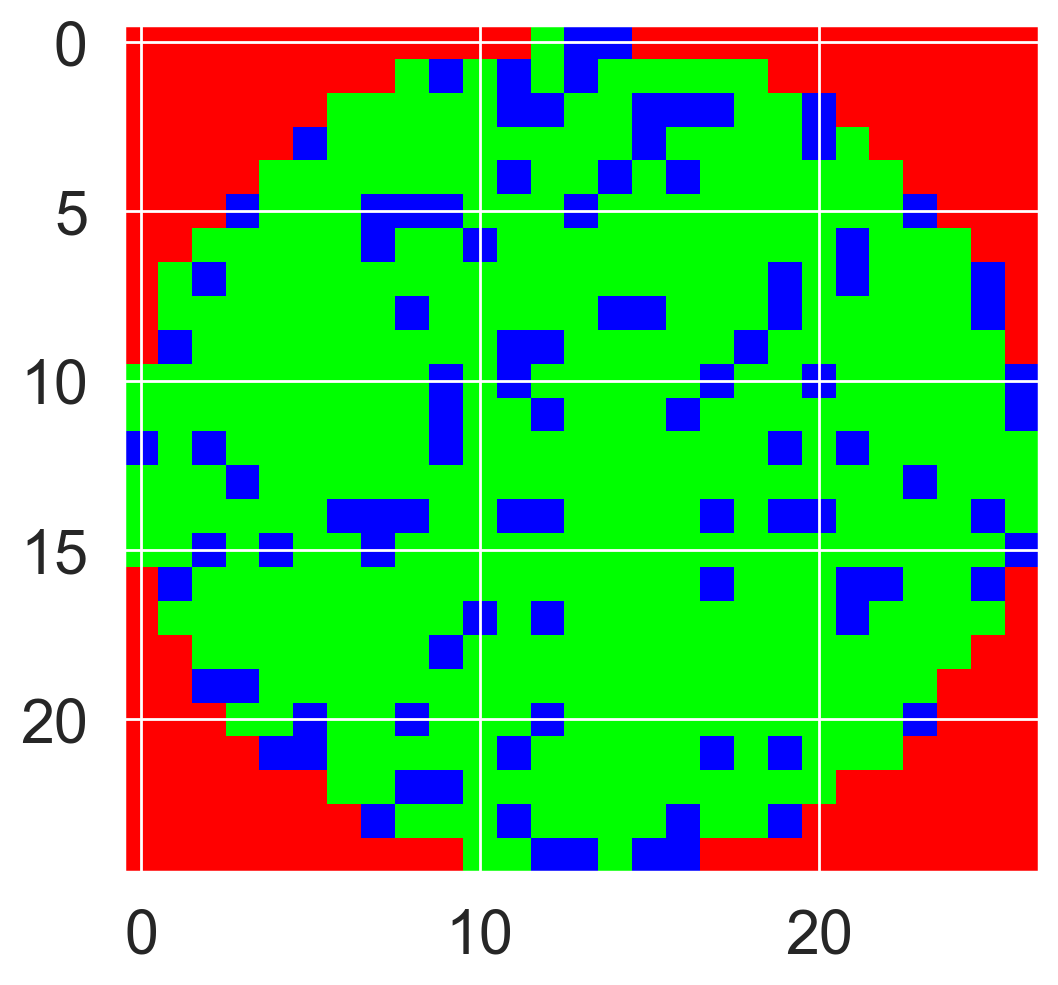

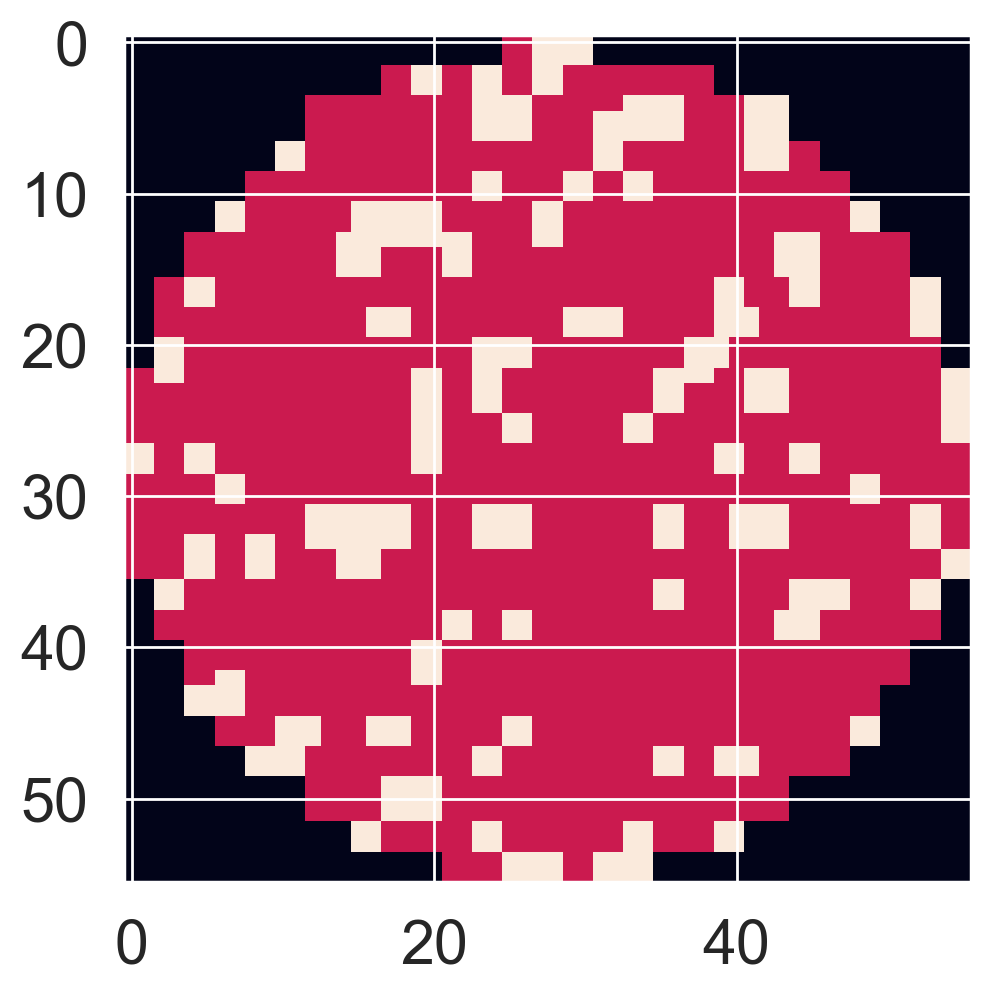

In [45]:
plt.imshow(rgb_x0[100])
plt.show()
plt.imshow(torch.argmax(resized_x0[100],axis=2).cpu().numpy())
plt.show()

In [40]:
resized_x0.reshape(1808, 3, 56, 56)

tensor([[[[1., 0., 0.,  ..., 0., 1., 0.],
          [0., 1., 0.,  ..., 0., 0., 1.],
          [0., 0., 1.,  ..., 1., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 1., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 1.],
          [0., 0., 1.,  ..., 1., 0., 0.]],

         [[1., 0., 0.,  ..., 1., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 1.],
          [0., 0., 1.,  ..., 1., 0., 0.],
          ...,
          [0., 0., 1.,  ..., 1., 0., 0.],
          [1., 0., 0.,  ..., 1., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 1.]],

         [[0., 0., 1.,  ..., 1., 0., 0.],
          [1., 0., 0.,  ..., 1., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 1.],
          ...,
          [1., 0., 0.,  ..., 0., 1., 0.],
          [0., 1., 0.,  ..., 0., 0., 1.],
          [0., 0., 1.,  ..., 1., 0., 0.]]],


        [[[1., 0., 0.,  ..., 0., 1., 0.],
          [0., 1., 0.,  ..., 0., 0., 1.],
          [0., 0., 1.,  ..., 1., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 1., 0., 0.],
        

Epoch [1/10], Loss: 0.2787
Epoch [2/10], Loss: 0.2334
Epoch [3/10], Loss: 0.2247
Epoch [4/10], Loss: 0.2225
Epoch [5/10], Loss: 0.2166
Epoch [6/10], Loss: 0.2062
Epoch [7/10], Loss: 0.2014
Epoch [8/10], Loss: 0.1939
Epoch [9/10], Loss: 0.1677
Epoch [10/10], Loss: 0.1492
Test Loss: 0.1332


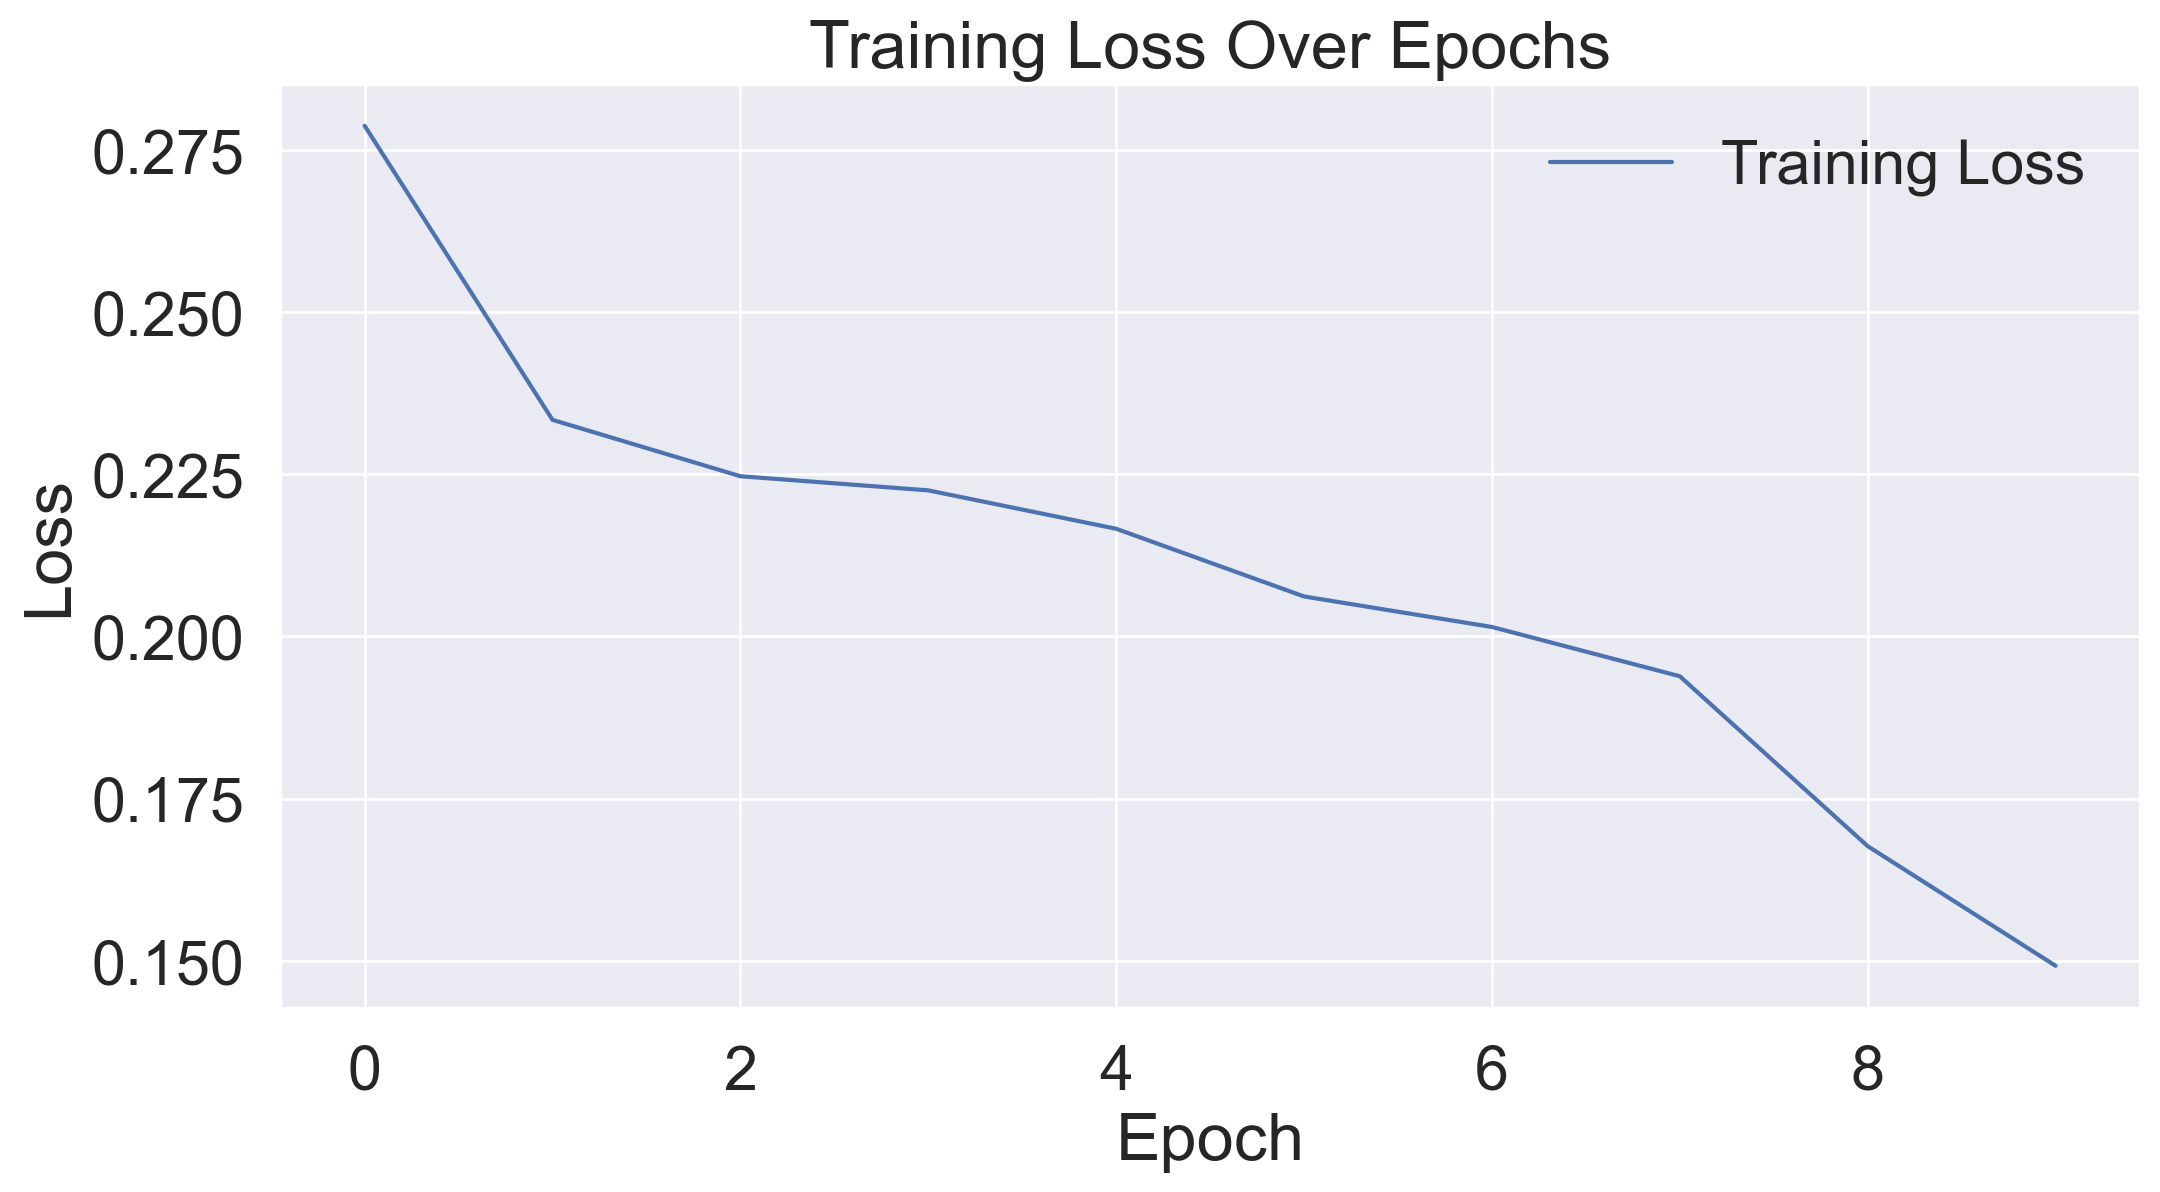

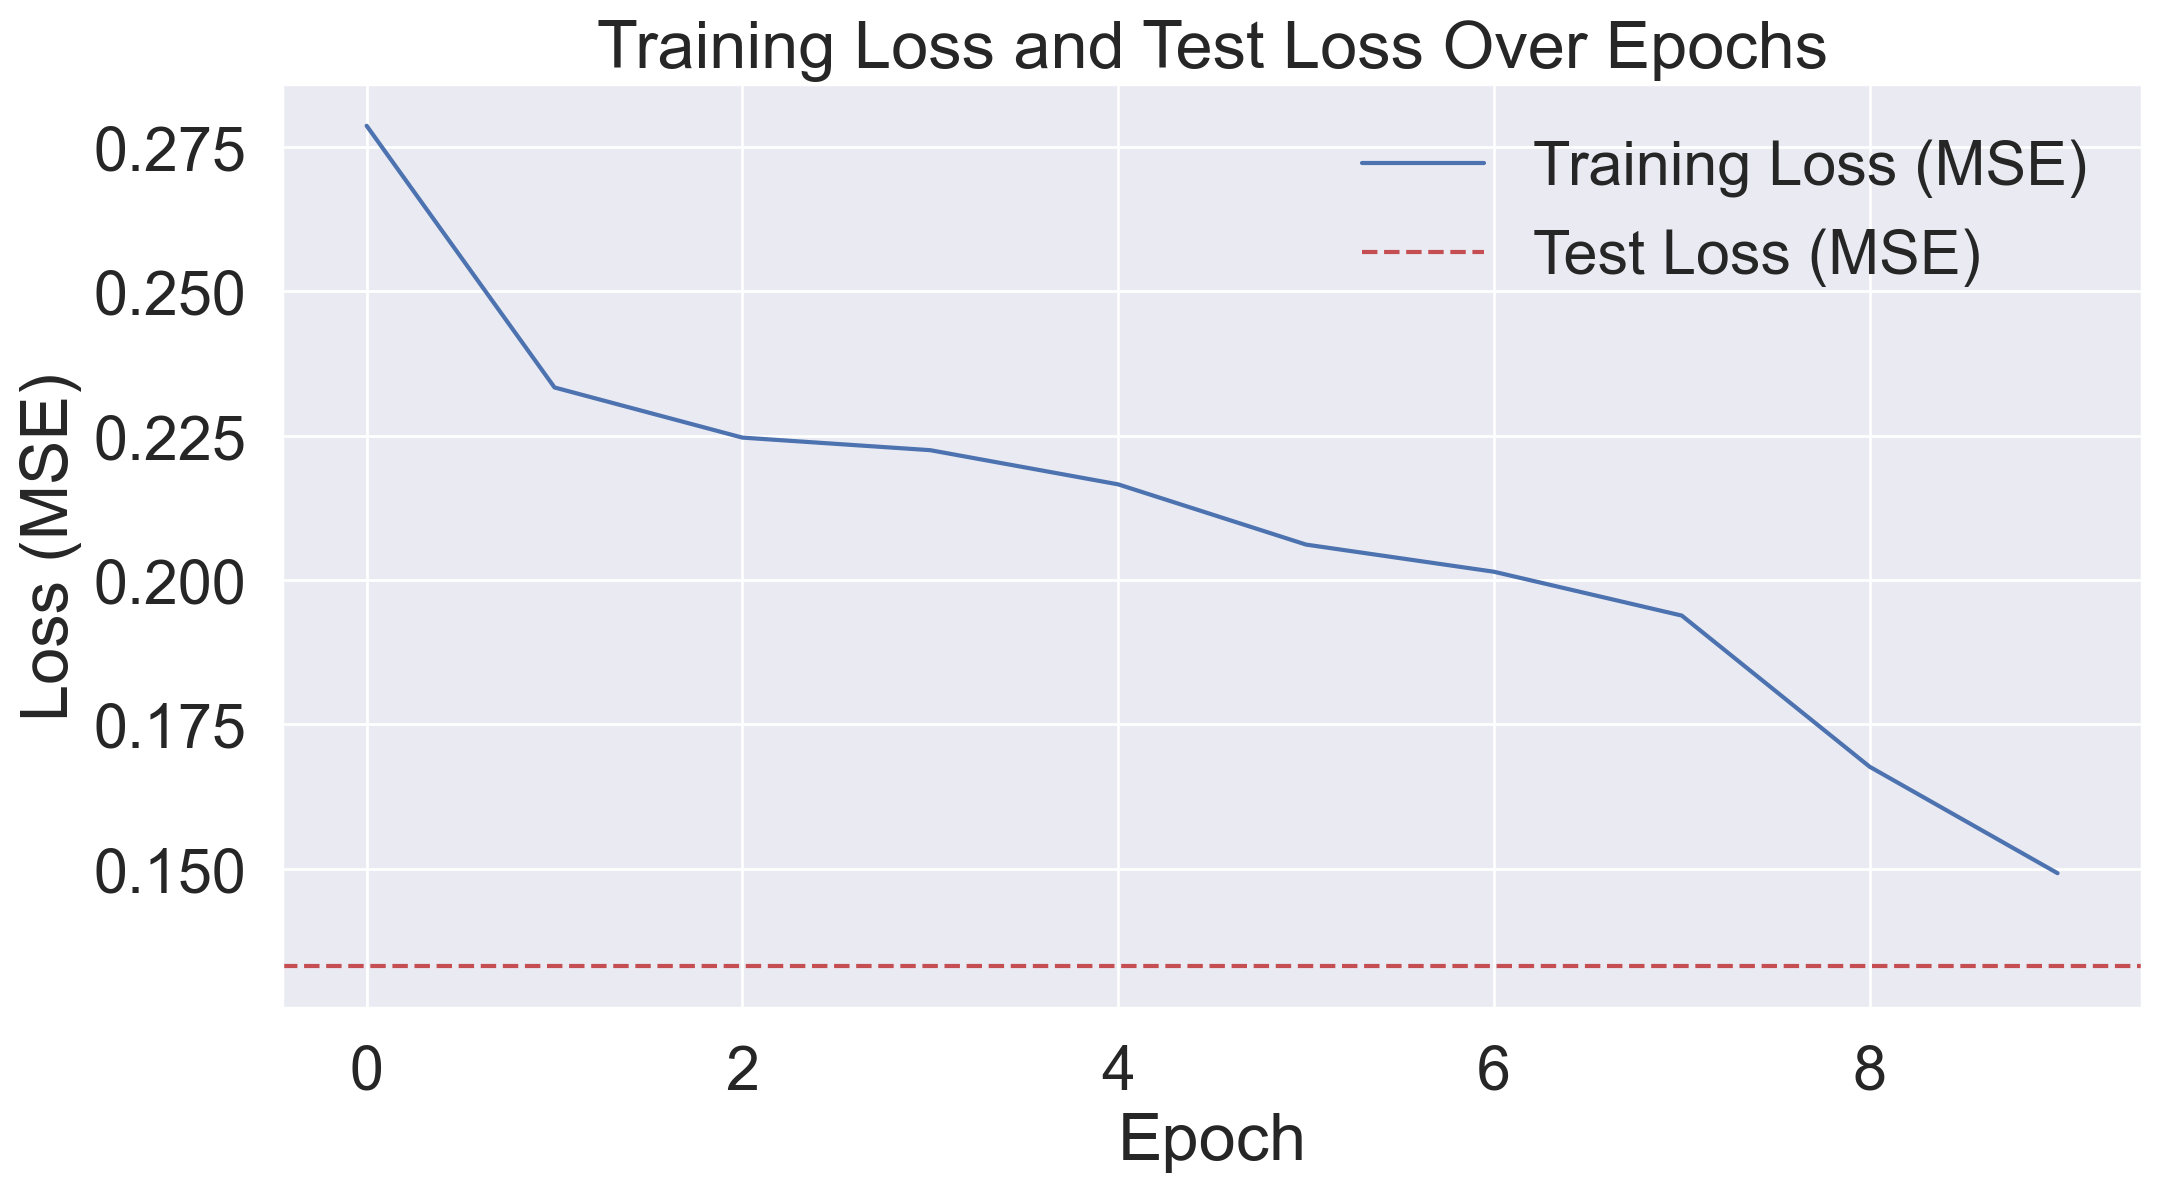

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # (56x56x3) -> (28x28x16)
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),  # (28x28x16) -> (14x14x8)
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, stride=2, padding=1),   # (14x14x8) -> (7x7x8)
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, padding=1, output_padding=1),  # (7x7x8) -> (14x14x8)
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (14x14x8) -> (28x28x16)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1)   # (28x28x16) -> (56x56x3)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Create synthetic image data
train_images = resized_x0.reshape(1808, 3, 56, 56) # resized_x0.reshape(1808, 3, 56, 56) torch.randn(1808, 3, 56, 56)  # Replace with actual training data
test_images = resized_x1.reshape(1405, 3, 56, 56) #torch.randn(1405, 3, 56, 56)   # Replace with actual test data

# Create datasets
train_dataset = TensorDataset(train_images)
test_dataset = TensorDataset(test_images)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    return train_losses

# Define evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_losses = []
    with torch.no_grad():
        for inputs, in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            test_losses.append(loss.item() * inputs.size(0))
    avg_test_loss = sum(test_losses) / len(test_loader.dataset)
    print(f'Test Loss: {avg_test_loss:.4f}')
    return avg_test_loss

# Initialize model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=10)

# Evaluate the model
test_loss = evaluate_model(model, test_loader, criterion)

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot additional metrics (e.g., MSE) as "accuracy"
# Since MSE is the same as loss, we use it as a metric here
def plot_metrics(train_losses, test_loss):
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss (MSE)')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss (MSE)')
    plt.title('Training Loss and Test Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

# Call plot_metrics
plot_metrics(train_losses, test_loss)


In [55]:
from torchsummary import summary
summary(model,(3,54,54), batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 16, 27, 27]             448
              ReLU-2           [16, 16, 27, 27]               0
            Conv2d-3            [16, 8, 14, 14]           1,160
              ReLU-4            [16, 8, 14, 14]               0
            Conv2d-5              [16, 8, 7, 7]             584
              ReLU-6              [16, 8, 7, 7]               0
   ConvTranspose2d-7            [16, 8, 14, 14]             584
              ReLU-8            [16, 8, 14, 14]               0
   ConvTranspose2d-9           [16, 16, 28, 28]           1,168
             ReLU-10           [16, 16, 28, 28]               0
  ConvTranspose2d-11            [16, 3, 56, 56]             435
Total params: 4,379
Trainable params: 4,379
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.53
Forward/back